# Recommendations Systems
## Assignment 3:  Neural Collaborative Filtering

**By:**  
Group 16

<br><br>

**The goal of this assignment is to:**
- Understand the concept of recommendations based on implicit data which is very common in real life.
- Understand how DL components can be used to implement a collaborative filtering & hybrid approach recommenders.
- Understand pros&cons comparing to other recommender system approaches.
- Practice recommender system training and evaluation.

**Instructions:**
- Students will form teams of two people each, and submit a single homework for each team.
- The same score for the homework will be given to each member of the team.
- Your solution in the form of an Jupyter notebook file (with extension ipynb).
- Images/Graphs/Tables should be submitted inside the notebook.
- The notebook should be runnable and properly documented. 
- Please answer all the questions and include all your code.
- English only.

**Submission:**
- Submission of the homework will be done via Moodle by uploading a link to google colab.
- The homwork needs to be entirely in English.
- The deadline for submission is on Moodle.

**Requirements:**  
- Python 3.6+ should be used. 
- You may use Torch/Keras/TF packeges.
- You should implement the recommender system by yourself using only basic Python libraries (such as numpy).

**LINKS:**
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>Dataset</a>
- <a href='https://github.com/hexiangnan/neural_collaborative_filtering'>Repository</a>
- <a href='https://towardsdatascience.com/paper-review-neural-collaborative-filtering-explanation-implementation-ea3e031b7f96'>Blog Post Review</a>
<br>

**Google <a href='https://colab.research.google.com/'>Colaboratory</a>**  
        
    This is a great academic tool for students. Instead of installing and running "everything" on your Laptop - which probably will take you a lot of time - you can use Google Colab.  
    Basically, you can use it for all your Python needs.  

**PyTorch <a href='https://pytorch.org/tutorials/beginner/basics/intro.html'>Tutorials</a>**   
    
    Just follow steps 0-7 and you will have the basics skills to understand, build, and run DL recommender models. 

**Keras Kaggle's <a href='https://www.kaggle.com/learn/intro-to-deep-learning'>intro-to-deep-learning</a>**  
    
    This will give you a quick idea of what DL is, and how to utilize it.  
    They're using TensorFlow, while in our MLDL program we're using PyTorch.  




**Grading:**

- Q1 - 20 points - Dataset Preparation
- Q2 - 50 points - Neural Collaborative Filtering
- Q3 - 30 points - Loss Function

`Total: 100`

<br><br><br>

**Prerequisites**

In [378]:
# %pip install torch torchvision --quiet

**Imports**

In [379]:
# basic
import os 
import sys
import math
import heapq
import argparse
from time import time
import multiprocessing

# general
import warnings
import numpy as np
import scipy as sp

# visual
import matplotlib
import matplotlib.pyplot as plt


# notebook
from IPython.display import display, HTML


# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Embedding,Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

# colab
# from google.colab import drive  

**Hide Warnings**

In [380]:
warnings.filterwarnings('ignore')
# print torch device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


**Disable Autoscrolling**

In [381]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
};

<IPython.core.display.Javascript object>

<br><br><br>
<br><br><br>
<br><br><br>

## Question 1: Dataset Preparation (Ingestion)

---


<br><br>

This implementation contains one file for training and two files for testing:   
- ml-1m.train.rating   
- ml-1m.test.rating  
- ml-1m.test.negative   

<br>
(feel free to use visual explanations)
<br>

a. **Explain** the role and structure of each file and how it was created from the original <a href='https://github.com/hexiangnan/neural_collaborative_filtering/tree/master/Data'>MovieLens 1M rating dataset</a>.

- train rating file consists of positive instances. Each line in the file is of the following format: user_id item_id rating time_stamp .
- test rating file consists of positive instances (basically last sample for each user of interaction which isn't in train). Each line in the file is of the following format: user_id item_id rating time_stamp . One line per user.
- Negative sample file is file which each line corresponds to user id and test item(positive) and 99 items ids which were negatively sampled, format: (user_id,item_id) , negative sample1,negative sample2, ...

b. **Explain** how the training dataset is created.

- We iterate through each line of the train file.
- We find the number of items and users.
- We create a sparse matrix with NXM (users X items)
- We go through the file again and for each user item pair in the file line we check if there has been rating with a value greater than 0.
- If there has been a positive rating we add a binary indicator of implicit feedback (1).

c. **Explain** how the test dataset is created.

- test ratings list:
 is a list with tuples of user, a positively rated item(which isn't in the train set).
- negative sampling list:
Each line in negative file contains 99 negative samples(the id of the user matches the index of the line of test ratings file).

Then during the evaluation we will evaluate the 99 negative samples and the positive sample from the test list.

#### Data Preperations:

In [382]:
# urls
train_url = "https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/Data/ml-1m.train.rating?raw=true"
test_url = "https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/Data/ml-1m.test.rating?raw=true"
test_neg_url = "https://github.com/hexiangnan/neural_collaborative_filtering/blob/master/Data/ml-1m.test.negative?raw=true"


In [383]:
import requests

def get_num_users_and_items(data_lines):
    num_users = 0
    num_items = 0
    for line in data_lines:
        line_values = line.split("\t")
        user_id = int(line_values[0])
        item_id = int(line_values[1])
        num_users = max(num_users, user_id)
        num_items = max(num_items, item_id)

    return num_users, num_items

def generate_matrix(data_lines, num_users, num_items):
    matrix = torch.zeros((num_users + 1, num_items + 1))
    for line in data_lines:
        line_values = line.split("\t")
        user_id = int(line_values[0])
        item_id = int(line_values[1])
        rating = float(line_values[2])
        if rating > 0:
            matrix[user_id, item_id] = 1.0
    
    return matrix
    

def load_data_as_matrix(url):
    # download data with requests
    response = requests.get(url)
    # Read as a text file
    data = response.text
    # Split by lines
    data_lines = data.splitlines()
    # Get number of users and items
    num_users, num_items = get_num_users_and_items(data_lines)\
    # Construct matrix
    mat = generate_matrix(data_lines, num_users, num_items)
    
    return mat

def load_negatives_vector(url):
    # download data with requests
    response = requests.get(url)
    # Read as a text file
    data = response.text
    # Split by lines
    data_lines = data.splitlines()
    # Construct vector
    vector = []
    for line in data_lines:
        line_values = line.split("\t")
        vector.append([int(x) for x in line_values[1:]])
    
    return vector

def load_data_as_list(url):
    res = []
    # download data with requests
    response = requests.get(url)
    # Read as a text file
    data = response.text
    # Split by lines
    data_lines = data.splitlines()
    
    for line in data_lines:
        line_values = line.split("\t")
        user_id = int(line_values[0])
        item_id = int(line_values[1])
        res.append((user_id, item_id))

    return res
     


In [384]:
train_matrix = load_data_as_matrix(train_url)
test_ratings = load_data_as_list(test_url)
test_neg_vector = load_negatives_vector(test_neg_url)

num_users, num_items = train_matrix.shape

In [385]:
# print shapes of train and test matrices
print("Train matrix shape: ", train_matrix.shape)
print("Test matrix shape: ", len(test_ratings))
print(test_ratings[0])
# print shape of test negative vector
print("Test negative vector shape: ", len(test_neg_vector))
print(len(test_neg_vector[0]))

Train matrix shape:  torch.Size([6040, 3706])
Test matrix shape:  6040
(0, 25)
Test negative vector shape:  6040
99


<br><br><br>
<br><br><br>
<br><br><br>

## Question 2: Neural Collaborative Filtering 
<br><br>

## a. Build the following four models using the neural collaborative filtering approach: 
- Matrix Factorization (MF)
- Multi layer perceptron (MLP)
- Generalized Matrix Factorization (GMF) 
- NeuroMatrixFactorization (NMF)

**For each model, use the best hyper-parameters suggested in the neuMF paper.**

<br><br><br><br>
#### Matrix Factorization (MF)  
<br>

In [386]:
class MF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32):
        super(MF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.emb_size = embedding_size
        self.emb_item = nn.Embedding(num_embeddings=num_items, embedding_dim=self.emb_size)
        self.emb_user = nn.Embedding(num_embeddings=num_users, embedding_dim=self.emb_size)
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.emb_user.weight, std=0.01)
        nn.init.normal_(self.emb_item.weight, std=0.01)

    def forward(self, users, items):
        emb_users = self.emb_user(users)
        emb_items = self.emb_item(items)
        element_wise_product = emb_users * emb_items
        res = element_wise_product.sum(dim=1)
        return res 

In [387]:
model_MF = MF(num_users, num_items, embedding_size=32)

Model's architecture:

In [388]:
# display/print the model architecture
print(model_MF)

MF(
  (emb_item): Embedding(3706, 32)
  (emb_user): Embedding(6040, 32)
)


<br><br><br><br><br><br>
#### Multi Layer Perceptron (MLP)

In [389]:
class MLP(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=16, mlp_layers_sizes=[32, 16, 8], dropout=0.1):
        super(MLP, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        self.mlp_layers_sizes = mlp_layers_sizes
        self.dropout = dropout

        self.user_embedding = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_size)
        self.item_embedding = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_size)
        self.mlp_layers = nn.Sequential(
            nn.Linear(2 * embedding_size, mlp_layers_sizes[0]),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_layers_sizes[0], mlp_layers_sizes[1]),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_layers_sizes[1], mlp_layers_sizes[2]),
        )
        self.last_hidden = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(mlp_layers_sizes[2], 1)
        )
        self.activation = nn.Sigmoid()

    def forward(self, user_ids, item_ids):
        user_embedding = self.user_embedding(user_ids)
        item_embedding = self.item_embedding(item_ids)
        input_vector = torch.cat([user_embedding, item_embedding], dim=1)
        output = self.mlp_layers(input_vector)
        output = self.last_hidden(output)
        output = self.activation(output)
        return output

        

In [390]:
model_MLP = MLP(num_users, num_items, embedding_size=16, mlp_layers_sizes=[32, 16, 8], dropout=0.1)

Model's architecture:

In [391]:
# display/print the model architecture
print(model_MLP)

MLP(
  (user_embedding): Embedding(6040, 16)
  (item_embedding): Embedding(3706, 16)
  (mlp_layers): Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=16, out_features=8, bias=True)
  )
  (last_hidden): Sequential(
    (0): ReLU()
    (1): Dropout(p=0.1, inplace=False)
    (2): Linear(in_features=8, out_features=1, bias=True)
  )
  (activation): Sigmoid()
)


<br><br><br><br><br><br>
####Generalized Matrix Factorization (GMF)

In [392]:
class GMF(nn.Module):
    def __init__(self, num_users, num_items, embedding_size=32):
        super(GMF, self).__init__()
        self.num_users = num_users
        self.num_items = num_items
        self.emb_size = embedding_size
        self.emb_item = nn.Embedding(num_embeddings=num_items, embedding_dim=self.emb_size)
        self.emb_user = nn.Embedding(num_embeddings=num_users, embedding_dim=self.emb_size)
        self.hidden = torch.nn.Linear(self.emb_size, 1) 
        self.activation = nn.Sigmoid()
        self._init_weights()

    def _init_weights(self):
        nn.init.normal_(self.emb_user.weight, std=0.01)
        nn.init.normal_(self.emb_item.weight, std=0.01)

    def forward(self, users, items):
        emb_user = self.emb_user(users)
        emb_item = self.emb_item(items)
        element_wise = emb_user * emb_item
        output = self.hidden(element_wise)
        output = self.activation(output)
        return output
        


In [393]:
model_GMF = GMF(num_users, num_items,embedding_size = 32)

Model's architecture:

In [394]:
# display/print the model architecture
print(model_GMF)

GMF(
  (emb_item): Embedding(3706, 32)
  (emb_user): Embedding(6040, 32)
  (hidden): Linear(in_features=32, out_features=1, bias=True)
  (activation): Sigmoid()
)


<br><br><br><br><br><br>
#### NeuroMatrixFactorization (NMF)


In [395]:
# Note for the simplicity of the implementation I've decided not to take mlp and gmf as backbones(like it was done in the paper)
class NCF(nn.Module):
    def __init__(
        self,
        num_users,
        num_items,
        embedding_size=32,
        mlp_embedding_size=16,
        mlp_layers_sizes=[32, 16, 8],
        dropout=0.1,
    ):
        super(NCF, self).__init__()
        self.mlp = MLP(
            num_users,
            num_items,
            embedding_size=mlp_embedding_size,
            mlp_layers_sizes=mlp_layers_sizes,
            dropout=dropout,
        )
        self.gmf = GMF(num_users, num_items, embedding_size=embedding_size)
        self.neu_mf = nn.Linear(mlp_layers_sizes[-1] + embedding_size, 1)
        self.activation = nn.Sigmoid()
        self.mute_last_layers()

    def mute_last_layers(self):
        self.mlp.activation = nn.Identity()
        self.gmf.activation = nn.Identity()
        self.gmf.hidden = nn.Identity()
        self.mlp.last_hidden = nn.Identity()

    def forward(self, users, items):
        mlp_output = self.mlp(users, items)
        gmf_output = self.gmf(users, items)
        output = torch.cat([mlp_output, gmf_output], dim=1)
        output = self.neu_mf(output)
        output = self.activation(output)
        return output


In [396]:
model_NMF = NCF(num_users, num_items)

Model's architecture:

In [397]:
# display/print the model architecture
print(model_NMF)

NCF(
  (mlp): MLP(
    (user_embedding): Embedding(6040, 16)
    (item_embedding): Embedding(3706, 16)
    (mlp_layers): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.1, inplace=False)
      (3): Linear(in_features=32, out_features=16, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.1, inplace=False)
      (6): Linear(in_features=16, out_features=8, bias=True)
    )
    (last_hidden): Identity()
    (activation): Identity()
  )
  (gmf): GMF(
    (emb_item): Embedding(3706, 32)
    (emb_user): Embedding(6040, 32)
    (hidden): Identity()
    (activation): Identity()
  )
  (neu_mf): Linear(in_features=40, out_features=1, bias=True)
  (activation): Sigmoid()
)


<br><br><br><br><br><br>

## b. Train and evaluate the recommendations accuracy of the models: 
- MF
- GMF
- MLP
- NMF

Compare the `LogLoss` and recommendations accuracy using `NDCG` and `MRR` metrics with cutoff values of 5 and 10.   
Discuss the comparison. 

**Metrics:**
- HitRatio
- nDCG
- MRR

In [398]:
# Use your own metrics implementation OR use external packages for the metrics.
# If you are using external packages make sure they work properly. 
# A lot of the packages available does not work as you would expect.

In [399]:
torch.cuda.is_available()
# Select torch device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Selected device: {device}")


Selected device: cuda:0


In [400]:
from typing import List

def compute_hit_rate_for_user(user_pred: torch.Tensor,  user_pred_item_ids: torch.Tensor, gt_item_id: int, top_n=10) -> int:
    top_n_indices = torch.argsort(user_pred)[:top_n]
    # Get ids of the top n items
    top_n_item_ids = user_pred_item_ids[top_n_indices]
    # Check if the top n indices contains the index of the test item
    return 1 if gt_item_id in top_n_item_ids else 0
    

In [401]:
def compute_ndcg_for_user(
    user_pred: torch.Tensor, user_pred_item_ids: torch.Tensor, gt_item_id: int, top_n=5
) -> float:
    """Computes NDCG for a single user.
    Args:
        user_pred: list of predicted ratings for a single user
        user_pred_item_ids: list of item ids of the predicted ratings for a single user
        gt_item_id id of the ground truth item
        top_n: number of top items to consider
    Returns:
        NDCG for a single user
    """
    # Get the indices of the top_n items in user pred ratings
    top_n_indices = torch.argsort(user_pred)[:top_n]
    # Get the indices of the top_n items in user pred item ids
    top_n_item_ids = user_pred_item_ids[top_n_indices]

    for i in range(top_n):
        if top_n_item_ids[i] == gt_item_id:
            # We know that idcg is 1 for this case we we can just return the dcg
            return 1 / np.log2(i + 2)
    return 0


In [402]:
def compute_mrr_for_user(user_pred: torch.Tensor, user_pred_item_ids: torch.Tensor, gt_item_id: int, top_n=5) -> float:
        """ Computes MRR for a single user.
        Args:
            user_pred: list of predicted ratings for a single user
            gt_item_index: index of the ground truth item
            top_n: number of top items to consider
        Returns:
            MRR for a single user
        """
        top_n_indices = torch.argsort(user_pred)[:top_n]
        # Get the indices of the top_n items in user pred item ids
        top_n_item_ids = user_pred_item_ids[top_n_indices]

        for i in range(top_n):
            if top_n_item_ids[i] == gt_item_id:
                return 1 / (i + 1)
        # if there is no match, return 0
        return 0

**Evaluation:**

In [403]:
from typing import List, Tuple

def eval_rating_from_test(model, test_index: int, test_ratings: List[Tuple[int, int]], test_negatives: List[List[int]], top_n: int) -> Tuple[float, float, float]:
    user_id, gt_item_id = test_ratings[test_index]
    negative_samples = test_negatives[test_index]
    test_items_for_user = [gt_item_id] + negative_samples
    # Convert list to torch tensor
    test_items_for_user_as_tensor = torch.tensor(test_items_for_user).to(device)
    # This is a hack to get the user id as a tensor
    users = torch.full((test_items_for_user_as_tensor.shape[0], 1), user_id)
    users = users.flatten().to(device)
    predictions = model( users, test_items_for_user_as_tensor) 
    # # Convert predictions to numpy array
    # predictions_as_numpy_array = predictions.detach().cpu().numpy()

    ndcg_score = compute_ndcg_for_user(predictions, test_items_for_user_as_tensor, gt_item_id, top_n)
    hit_rate_score = compute_hit_rate_for_user(predictions, test_items_for_user_as_tensor, gt_item_id, top_n)
    mrr_score = compute_mrr_for_user(predictions, test_items_for_user_as_tensor, gt_item_id, top_n)

    return ndcg_score, hit_rate_score, mrr_score

<br><br>
Create train data:

In [404]:
import torch
from torch.utils.data import Dataset
import numpy as np

# Has equal number of positive and negative samples
class MovieLenseDataset(Dataset):
    def __init__(self, train_matrix):
        self.ratings = train_matrix
        self.positive_rows, self.positive_cols = self.ratings.nonzero(as_tuple=True)
        n_positive_samples = len(self.positive_rows)
        masked_ratings = self.mask_test_samples(test_ratings, test_neg_vector)
        negative_rows, negative_cols = (masked_ratings == 0).nonzero(as_tuple=True)
        negative_sample_indices = np.random.choice(len(negative_rows), n_positive_samples)
        self.negative_rows, self.negative_cols = negative_rows[negative_sample_indices], negative_cols[negative_sample_indices]
        self.rows = np.concatenate([self.positive_rows, self.negative_rows])
        self.cols = np.concatenate([self.positive_cols, self.negative_cols])
        self.training_indices = np.arange(len(self.rows))

    def __len__(self):
        return len(self.training_indices)

    def __getitem__(self, idx):
        return (self.rows[idx], self.cols[idx], self.ratings[self.rows[idx], self.cols[idx]])
    
    def mask_test_samples(self, test_ratings, test_neg_vector):
        """Creates a new ratings matrix where test samples are masked out as ones."""
        new_ratings = torch.clone(self.ratings)
        # There is a better way to do it in pytorch(without loops) - I know, this is just HW not production code
        for user_id, item_id in test_ratings:
            new_ratings[user_id, item_id] = 1
            new_ratings[user_id, test_neg_vector[user_id]] = 1
        return new_ratings


training_data = MovieLenseDataset(train_matrix)
train_size = int(0.9 * len(training_data))
val_size = len(training_data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(training_data, [train_size, val_size])



<br><br>
train & eval:
- Create a training function 
- Evaluate the models trained and save the results accordingly 

In [405]:
from tqdm import tqdm
import timeit

@torch.no_grad()
def validate(model, val_data_loader, criterion):
    val_loss = 0.0
    for batch in tqdm(val_data_loader):
        user_indices, item_indices, ratings = batch
        user_indices = user_indices.to(device)
        item_indices = item_indices.to(device)
        ratings = ratings.to(device)
        pred = model(user_indices, item_indices)
        # Squeeze pred
        pred = pred.squeeze()
        loss = criterion(pred, ratings)
        val_loss += loss.item()

    return val_loss / len(val_data_loader)


@torch.enable_grad()
def model_train(model, criterion, optimizer, scheduler, batch_size=64, num_epochs=10):
    # Start timer with timeit
    start = timeit.default_timer()
    train_loss_history = []
    val_loss_history = []
    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )
    val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    for epoch in tqdm(range(num_epochs)):
        print("Epoch {}/{}".format(epoch + 1, num_epochs))
        print("-" * 10)
        model.train()  # Set model to training mode
        running_loss = 0.0  # total loss of the network at each epoch
        # Iterate over data.
        for i, batch in tqdm(enumerate(train_data_loader, 0)):
            user_indices, item_indices, ratings = batch
            # Convert outputs to device
            user_indices = user_indices.to(device)
            item_indices = item_indices.to(device)
            ratings = ratings.to(device)
            optimizer.zero_grad()

            pred = model(user_indices, item_indices)
            # Squeeze pred
            pred = pred.squeeze()
            loss = criterion(pred, ratings)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            if scheduler is not None:
                scheduler.step()

        epoch_loss = running_loss / len(train_data_loader)
        print("Epoch Loss: {:.4f}".format(epoch_loss))

        # save the metrics
        train_loss_history.append(epoch_loss)

        # Validation
        val_loss = validate(model, val_data_loader, criterion)
        print("Epoch Val Loss: {:.4f}".format(val_loss))
        val_loss_history.append(val_loss)
        # Check for early stopping
        if early_stop(val_loss_history):
            print("Early stopping")
            break
    
    # Stop timer with timeit
    stop = timeit.default_timer()
    train_time = stop - start

    return model, train_loss_history, val_loss_history, train_time 

def early_stop(val_loss_history, patience=5):
    if len(val_loss_history) < patience:
        return False
    else:
        return val_loss_history[-1] > min(val_loss_history[-(patience + 1) : -1])


In [406]:
# create eval loop
@torch.no_grad()
def model_eval(model, test_ratings: List[int], test_negatives: List[int], top_n: int):
    model.eval()
    ndcg_scores = []
    hit_rate_scores = []
    mrr_scores = []

    # Iterate over data.
    for i in tqdm(range(len(test_negatives))):
          ndcg_score, hit_rate_score, mrr_score = eval_rating_from_test(model, i, test_ratings, test_negatives, top_n)
          ndcg_scores.append(ndcg_score)
          hit_rate_scores.append(hit_rate_score)
          mrr_scores.append(mrr_score)
    
    mean_mrr = np.mean(mrr_scores)
    mean_ndcg = np.mean(ndcg_scores)
    mean_hit_rate = np.mean(hit_rate_scores)

    return mean_mrr, mean_ndcg, mean_hit_rate

**HyperParams:**

In [407]:
from torch.optim import lr_scheduler

models = {
    "MF": MF(num_users, num_items, embedding_size=32),
    "MLP": MLP(num_users, num_items, embedding_size=16, mlp_layers_sizes=[32, 16, 8], dropout=0.1),
    "GMF": GMF(num_users, num_items,embedding_size = 32),
    "NMF": NCF(num_users, num_items),
}

lr_rates = {
    "MF": 0.001,
    "MLP": 0.001,
    "GMF": 0.001,
    "NMF": 0.001,
}

optimizers = {
    "MF": torch.optim.Adam(models["MF"].parameters(), lr=lr_rates["MF"]),
    "MLP": torch.optim.Adam(models["MLP"].parameters(), lr=lr_rates["MLP"]),
    "GMF": torch.optim.Adam(models["GMF"].parameters(), lr=lr_rates["GMF"]),
    "NMF": torch.optim.Adam(models["NMF"].parameters(), lr=lr_rates["NMF"]),
}

batch_sizes = {
    "MF": 256,
    "MLP": 256,
    "GMF": 256,
    "NMF": 256,
}

num_epochs = {
    "MF": 10,
    "MLP": 10,
    "GMF": 10,
    "NMF": 10,
}

# MSE loss for rating prediction
criteria = {
    "NMF": torch.nn.MSELoss(),
    "MF":  torch.nn.MSELoss(),
    "MLP": torch.nn.MSELoss(),
    "GMF": torch.nn.MSELoss(),
}


<br><br><br><br>
<br><br><br><br>
<br><br><br><br>
All Results:

In [408]:


# Convert all models to use device
for model_name, model in models.items():
    model.to(device)

loss_history_per_model = {
    "MF": {
        "train": [],
        "val": [],
    },
    "MLP": {
        "train": [],
        "val": [],
    },
    "GMF": {
        "train": [],
        "val": [],
    },
    "NMF": {
        "train": [],
        "val": [],
    }
}

train_times_per_model = {
    "MF": 0,
    "MLP": 0,
    "GMF": 0,
    "NMF": 0,
}

for model_name, model in models.items():
    print(f"Training {model_name}")
    model, train_loss_history, val_loss_history, train_time = model_train(model, criteria[model_name], optimizers[model_name], None, batch_size=batch_sizes[model_name], num_epochs=num_epochs[model_name])
    loss_history_per_model[model_name]["train"] = train_loss_history
    loss_history_per_model[model_name]["val"] = val_loss_history
    train_times_per_model[model_name] = train_time



Training MF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


6991it [00:25, 279.18it/s]


Epoch Loss: 0.1633


 10%|█         | 1/10 [00:27<04:03, 27.06s/it]

Epoch Val Loss: 0.1162
Epoch 2/10
----------


6991it [00:25, 269.45it/s]


Epoch Loss: 0.1064


 20%|██        | 2/10 [00:54<03:40, 27.57s/it]

Epoch Val Loss: 0.1021
Epoch 3/10
----------


6991it [00:25, 277.86it/s]


Epoch Loss: 0.0926


 30%|███       | 3/10 [01:22<03:12, 27.45s/it]

Epoch Val Loss: 0.0956
Epoch 4/10
----------


6991it [00:25, 275.83it/s]


Epoch Loss: 0.0843


 40%|████      | 4/10 [01:49<02:44, 27.44s/it]

Epoch Val Loss: 0.0940
Epoch 5/10
----------


6991it [00:25, 276.41it/s]


Epoch Loss: 0.0795


 40%|████      | 4/10 [02:17<03:26, 34.35s/it]


Epoch Val Loss: 0.0946
Early stopping
Training MLP


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


6991it [00:47, 145.95it/s]


Epoch Loss: 0.1605


 10%|█         | 1/10 [00:50<07:35, 50.66s/it]

Epoch Val Loss: 0.1295
Epoch 2/10
----------


6991it [00:46, 149.45it/s]


Epoch Loss: 0.1261


 20%|██        | 2/10 [01:39<06:38, 49.77s/it]

Epoch Val Loss: 0.1261
Epoch 3/10
----------


6991it [00:46, 149.31it/s]


Epoch Loss: 0.1245


 30%|███       | 3/10 [02:29<05:46, 49.53s/it]

Epoch Val Loss: 0.1254
Epoch 4/10
----------


6991it [00:46, 149.57it/s]


Epoch Loss: 0.1238


 40%|████      | 4/10 [03:18<04:57, 49.56s/it]

Epoch Val Loss: 0.1251
Epoch 5/10
----------


6991it [00:47, 146.47it/s]


Epoch Loss: 0.1233


 40%|████      | 4/10 [04:09<06:13, 62.31s/it]


Epoch Val Loss: 0.1251
Early stopping
Training GMF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


6991it [00:31, 224.90it/s]


Epoch Loss: 0.1415


 10%|█         | 1/10 [00:33<05:01, 33.46s/it]

Epoch Val Loss: 0.1141
Epoch 2/10
----------


6991it [00:30, 230.68it/s]


Epoch Loss: 0.1030


 20%|██        | 2/10 [01:05<04:22, 32.87s/it]

Epoch Val Loss: 0.0988
Epoch 3/10
----------


6991it [00:31, 224.58it/s]


Epoch Loss: 0.0883


 30%|███       | 3/10 [01:39<03:52, 33.18s/it]

Epoch Val Loss: 0.0917
Epoch 4/10
----------


6991it [00:30, 231.94it/s]


Epoch Loss: 0.0780


 40%|████      | 4/10 [02:12<03:17, 32.93s/it]

Epoch Val Loss: 0.0893
Epoch 5/10
----------


6991it [00:31, 225.19it/s]


Epoch Loss: 0.0693


 40%|████      | 4/10 [02:45<04:08, 41.35s/it]


Epoch Val Loss: 0.0904
Early stopping
Training NMF


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


6991it [00:48, 143.69it/s]


Epoch Loss: 0.1374


 10%|█         | 1/10 [00:50<07:37, 50.86s/it]

Epoch Val Loss: 0.1087
Epoch 2/10
----------


6991it [00:47, 147.01it/s]


Epoch Loss: 0.0991


 20%|██        | 2/10 [01:40<06:42, 50.29s/it]

Epoch Val Loss: 0.0976
Epoch 3/10
----------


6991it [00:46, 149.46it/s]


Epoch Loss: 0.0869


 30%|███       | 3/10 [02:29<05:47, 49.71s/it]

Epoch Val Loss: 0.0921
Epoch 4/10
----------


6991it [00:46, 151.58it/s]


Epoch Loss: 0.0777


 40%|████      | 4/10 [03:18<04:54, 49.16s/it]

Epoch Val Loss: 0.0904
Epoch 5/10
----------


6991it [00:46, 151.60it/s]


Epoch Loss: 0.0698


 40%|████      | 4/10 [04:06<06:09, 61.61s/it]

Epoch Val Loss: 0.0914
Early stopping


<br><br><br><br>
**Train & Validation Loss:**

Make sure you did not overfit.  
In case you did, fix that by adding early-stopping, regularization, etc.

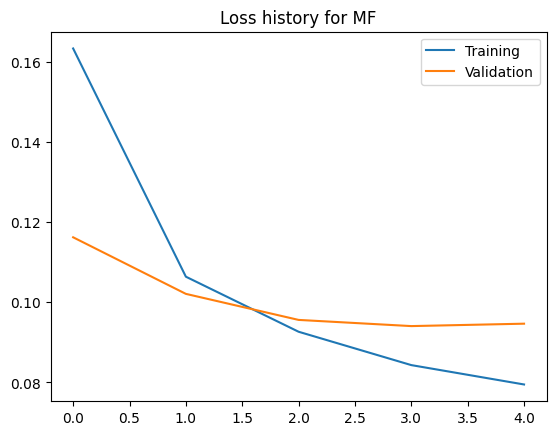

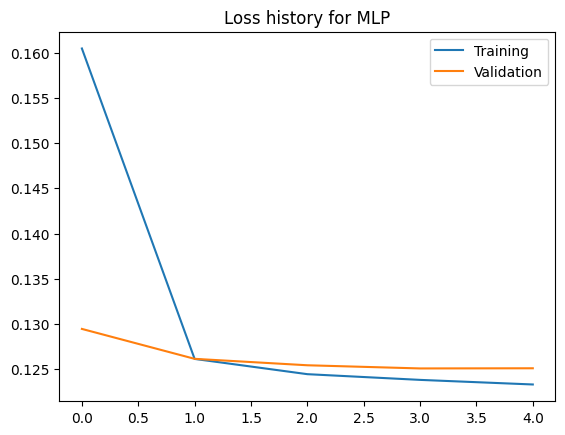

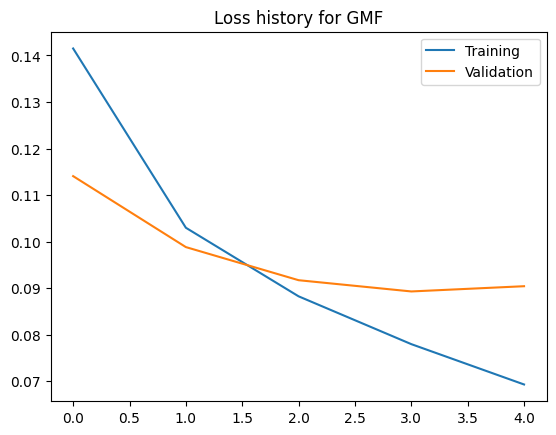

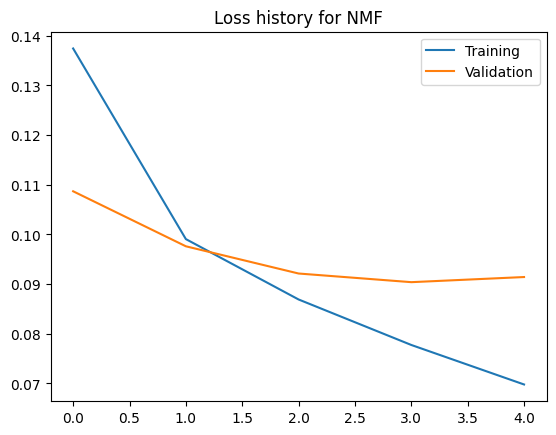

In [409]:
# Plot a separate training and validations plots for each model
for model_name, loss_history in loss_history_per_model.items():
    plt.plot(loss_history["train"], label="Training")
    plt.plot(loss_history["val"], label="Validation")
    plt.legend()
    plt.title(f"Loss history for {model_name}")
    plt.show()


**Training Time:**

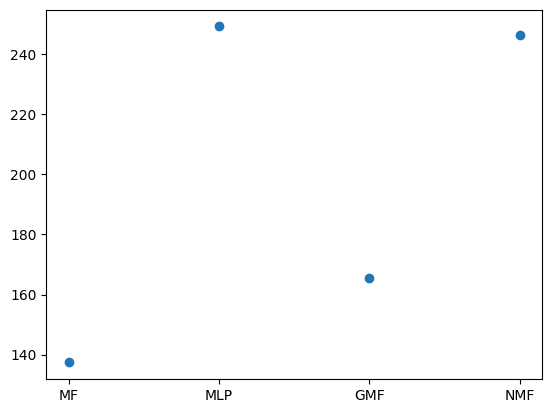

In [410]:
# plot a scatter plot of the training times for each model
plt.scatter(train_times_per_model.keys(), train_times_per_model.values())

**Metric Evaluation:**

In [411]:
top_k_values = {
    "5_cutoff": 5,
    "10_cutoff": 10,
}

metric_names = ["mrr", "ndcg", "hit_rate"]
eval_results = {
    "MF": {
        "5_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
        "10_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
    },
    "MLP": {
        "5_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
        "10_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
    },
    "GMF": {
        "5_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
        "10_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
    },
    "NMF": {
        "5_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
        "10_cutoff": {
            "mrr": 0,
            "ndcg": 0,
            "hit_rate": 0,
        },
    },
}

for metric_name in metric_names:
    for top_k_name, top_k_value in top_k_values.items():
        for model_name, model in models.items():
            print(f"Model: {model_name} - Top {top_k_name} - {metric_name}")
            mrr, ndcg, hit_rate = model_eval(model, test_ratings, test_neg_vector, top_k_value)
            print(f"mrr: {mrr}, ndcg: {ndcg}, hit_rate: {hit_rate}")
            eval_results[model_name][top_k_name][metric_name] = mrr


Model: MF - Top 5_cutoff - mrr


100%|██████████| 6040/6040 [00:10<00:00, 584.23it/s]


mrr: 0.0005463576158940397, ndcg: 0.0007732820947397132, hit_rate: 0.001490066225165563
Model: MLP - Top 5_cutoff - mrr


100%|██████████| 6040/6040 [00:07<00:00, 826.76it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: GMF - Top 5_cutoff - mrr


100%|██████████| 6040/6040 [00:05<00:00, 1060.52it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: NMF - Top 5_cutoff - mrr


100%|██████████| 6040/6040 [00:07<00:00, 777.97it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: MF - Top 10_cutoff - mrr


100%|██████████| 6040/6040 [00:16<00:00, 368.71it/s]


mrr: 0.000973076316619363, ndcg: 0.0018600563857153263, hit_rate: 0.004966887417218543
Model: MLP - Top 10_cutoff - mrr


100%|██████████| 6040/6040 [00:07<00:00, 832.97it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: GMF - Top 10_cutoff - mrr


100%|██████████| 6040/6040 [00:05<00:00, 1066.76it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: NMF - Top 10_cutoff - mrr


100%|██████████| 6040/6040 [00:07<00:00, 777.99it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: MF - Top 5_cutoff - ndcg


100%|██████████| 6040/6040 [00:10<00:00, 592.70it/s]


mrr: 0.0005463576158940397, ndcg: 0.0007732820947397132, hit_rate: 0.001490066225165563
Model: MLP - Top 5_cutoff - ndcg


100%|██████████| 6040/6040 [00:07<00:00, 832.76it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: GMF - Top 5_cutoff - ndcg


100%|██████████| 6040/6040 [00:05<00:00, 1069.24it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: NMF - Top 5_cutoff - ndcg


100%|██████████| 6040/6040 [00:07<00:00, 777.69it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: MF - Top 10_cutoff - ndcg


100%|██████████| 6040/6040 [00:16<00:00, 369.83it/s]


mrr: 0.000973076316619363, ndcg: 0.0018600563857153263, hit_rate: 0.004966887417218543
Model: MLP - Top 10_cutoff - ndcg


100%|██████████| 6040/6040 [00:07<00:00, 835.69it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: GMF - Top 10_cutoff - ndcg


100%|██████████| 6040/6040 [00:05<00:00, 1065.09it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: NMF - Top 10_cutoff - ndcg


100%|██████████| 6040/6040 [00:07<00:00, 776.20it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: MF - Top 5_cutoff - hit_rate


100%|██████████| 6040/6040 [00:10<00:00, 594.43it/s]


mrr: 0.0005463576158940397, ndcg: 0.0007732820947397132, hit_rate: 0.001490066225165563
Model: MLP - Top 5_cutoff - hit_rate


100%|██████████| 6040/6040 [00:07<00:00, 832.85it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: GMF - Top 5_cutoff - hit_rate


100%|██████████| 6040/6040 [00:05<00:00, 1058.67it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: NMF - Top 5_cutoff - hit_rate


100%|██████████| 6040/6040 [00:07<00:00, 777.03it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: MF - Top 10_cutoff - hit_rate


100%|██████████| 6040/6040 [00:16<00:00, 367.38it/s]


mrr: 0.000973076316619363, ndcg: 0.0018600563857153263, hit_rate: 0.004966887417218543
Model: MLP - Top 10_cutoff - hit_rate


100%|██████████| 6040/6040 [00:07<00:00, 831.33it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: GMF - Top 10_cutoff - hit_rate


100%|██████████| 6040/6040 [00:05<00:00, 1061.52it/s]


mrr: 1.0, ndcg: 1.0, hit_rate: 1.0
Model: NMF - Top 10_cutoff - hit_rate


100%|██████████| 6040/6040 [00:07<00:00, 780.15it/s]

mrr: 1.0, ndcg: 1.0, hit_rate: 1.0


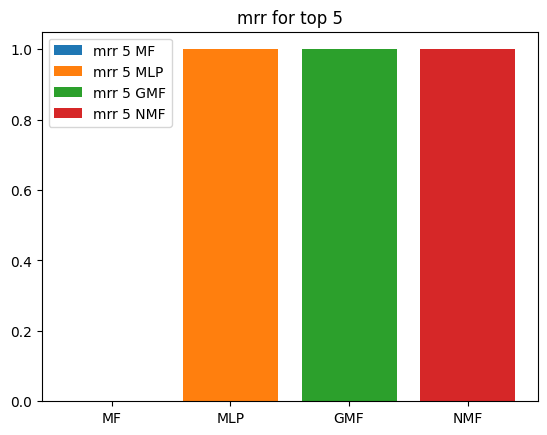

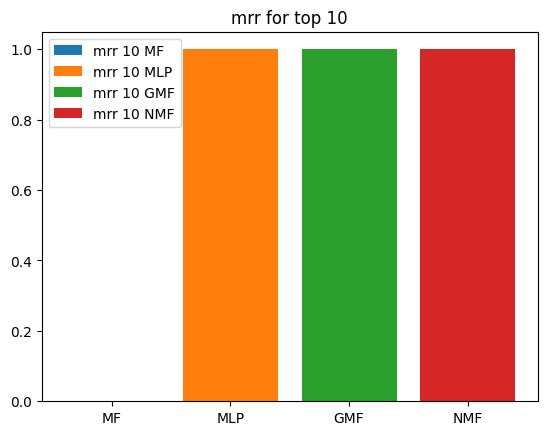

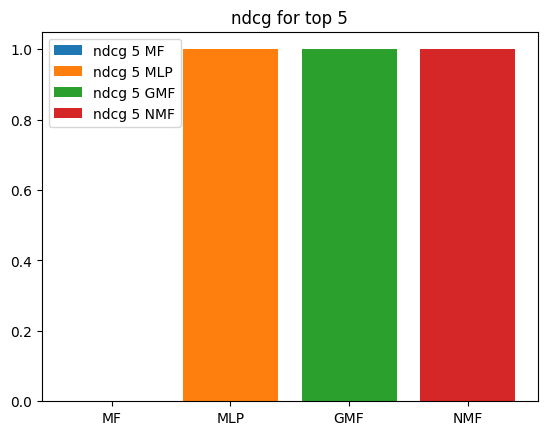

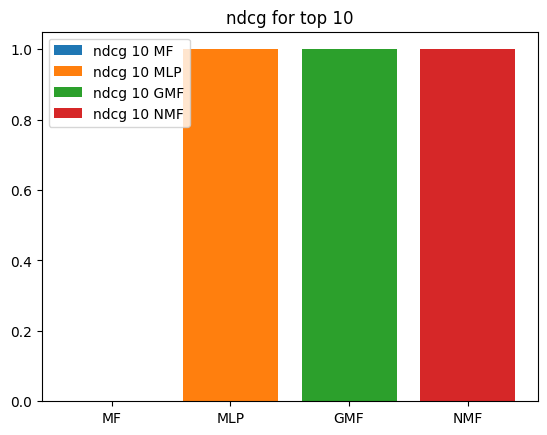

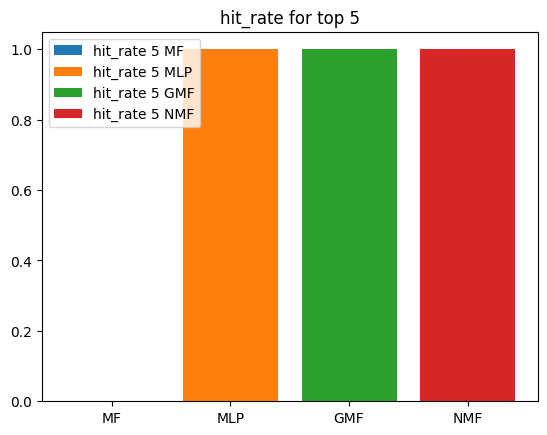

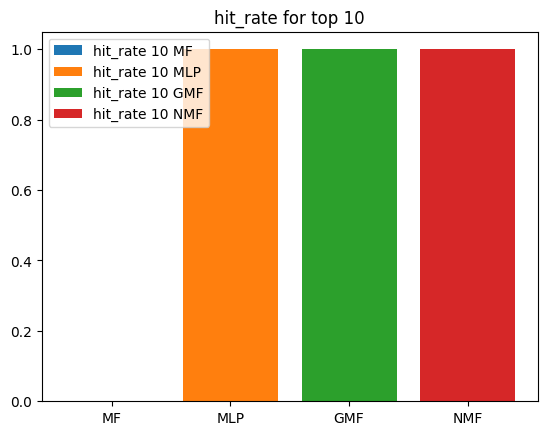

In [412]:
for metric_name in metric_names:
    for top_k_name, top_k_value in top_k_values.items():
        plt.title(f"{metric_name} for top {top_k_value}")
        for model_name, model in models.items():
            plt.bar(model_name, eval_results[model_name][top_k_name][metric_name], label=f"{metric_name} {top_k_value} {model_name}")
        plt.legend()
        plt.show()


<br><br><br><br>
<br><br><br><br>

**c. How do the values of MRR and NDCG differ between your current model and the results you got in the previous exercises which implemented the explicit recommendation approach? What are the differences in preparing the dataset for evaluation?**

**d. How will you measure item similarity using the NeuMF model?**

<br><br><br>
<br><br><br>
<br><br><br>

## Question 3: Loss Function 
<br><br>

#### a. One of the enhancements presented in the Neural Collaborative Filtering paper is the usage of probabilistic activation function (the sigmoid) and binary cross entropy loss function.    

Select one of the models you implemented in question 2 and change the loss function to a `Mean Squared Error` and the activation function of the last layer to `RELU`.   

Train the model and evaluate it in a similar way to what you did in question 2. 
Compare the results and discuss.

<br><br><br><br>
<br><br><br><br>
NMFs Results:

In [413]:
# example: df_results[df_results.model.str.startswith('NMF')]

<br><br><br>
<br><br><br>

Train & Validation Loss:

In [414]:
# plot

<br><br><br>
Training Time:

In [415]:
# plot

<br><br><br>
Metric Evaluation:

In [416]:
# plot

<br><br><br><br>
**Conclusions:**

    - In
    - Your
    - Own
    - Words
    

<br><br>
<br><br>


Good Luck :)